In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import pandas as pd

from notebook_utils import *

In [3]:
all_metrics = {}

In [4]:
strategies_names = ["aleatoric_propagated", "educated_random", "augment_latent", "age","anrmab", "entropy","tta_expected_query_score", "random"]
metrics_dict_cora_gcn = load_results("cora_ml", "gcn", strategies_names, save=False, cached=True, cache_path="../other_data")
all_metrics[("cora_ml", "gcn")] = metrics_dict_cora_gcn

Loading cached metrics


/home/banfizsombor/work/uq-for-al-on-graphs/notebooks/notebook_utils.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metrics_dict = torch.load(metrics_path)


In [5]:
strategies_names = ["aleatoric_propagated", "age","anrmab", "entropy", "random"]
metrics_dict_cora_sgc = load_results("cora_ml", "sgc", strategies_names, save=False, cached=False, cache_path="../other_data")
all_metrics[("cora_ml", "sgc")] = metrics_dict_cora_sgc

Loading metrics cora_ml sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
	random metrics


In [6]:
for dataset in ["citeseer", "pubmed", "amazon_photos"]:
    for model in ["gcn", "sgc"]:
        strategies_names = ["aleatoric_propagated", "age","anrmab", "entropy"]
        metrics_dict = load_results(dataset, model, strategies_names, save=False, cached=False, cache_path="../other_data")
        all_metrics[(dataset, model)] = metrics_dict

Loading metrics citeseer gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics citeseer sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics pubmed gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics pubmed sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics amazon_photos gcn
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics
Loading metrics amazon_photos sgc
	aleatoric_propagated metrics
	age metrics
	anrmab metrics
	entropy metrics


In [7]:
runs = combine_geem_metrics("cora_ml")
agg, stds = aggregate_geem_metrics("cora_ml")
# all_metrics[("cora_ml", "gcn")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)
all_metrics[("cora_ml", "sgc")]["geem"] = (agg["accuracy/test"], stds["accuracy/test"], agg, runs)


In [8]:
df_combineds = {}
for (dataset,model), metrics_dict in all_metrics.items():
    df_combined, df = create_df(metrics_dict)
    df_combineds[(dataset,model)] = (df_combined,df)

In [9]:
df_combined, df = df_combineds[("cora_ml", "gcn")]

In [10]:
strategy_mapping = {
 "aleatoric": "LC",
 "educated": "ER",
 "augment": "LC",
}

In [59]:
df_combined = []
for d_m_key in [("cora_ml", "sgc"), ("cora_ml", "gcn")]:    
    # d_m_key = ("cora_ml", "sgc")
    df_tmp = df_combineds[d_m_key][0].copy()
    l = [get_count_dict(all_metrics[d_m_key][x][3]) for x in df_tmp.index]
    df_tmp["num_acquired_indices"] = [len(i[0]) for i in l]
    df_tmp["num_acquired_indices"] /= 700
    binned_stats = [get_count_dict_binned_stats(all_metrics[d_m_key][x][3]) for x in df_tmp.index]
    df_tmp["num_acquired_by_split"] = [i[0] for i in binned_stats]
    df_tmp["num_acquired_by_init"] = [i[1] for i in binned_stats]
    df_tmp["max_acquired"] = [i[1].max().item() for i in l]
    df_tmp["max_acquired_index"] = [i[1].argmax().item() for i in l]
    df_tmp["strategy"] = [i.split("_")[0] for i in df_tmp.index]
    df_tmp["tta"] = ["TTA" if ("probs" in i) or ("logits" in i) or ("latent" in i)  else "EQS" if "tta" in i else "NO" for i in df_tmp.index]
    df_tmp["filter"] = [True if "_filter" in i else False for i in df_tmp.index]
    if len(df_tmp.loc[(df_tmp["tta"] == "EQS"), "strategy"]) > 0:
        df_tmp.loc[(df_tmp["tta"] == "EQS"), "strategy"] = [x.split("_")[4] for x in df_tmp.loc[(df_tmp["tta"] == "EQS")].index]
    df_tmp["adapted"] = df_tmp.index.str.contains("iquery")
    df_tmp["strategy"] = df_tmp["strategy"].map(strategy_mapping).fillna(df_tmp["strategy"])
    df_tmp["strategy"] = df_tmp["strategy"].str.upper()
    df_tmp["dataset"] = d_m_key[0]
    df_tmp["model"] = d_m_key[1]
    df_tmp["name_final"] = df_tmp.apply(name_fn, axis=1)
    df_tmp["name_final2"] = df_tmp["strategy"]
    df_tmp.loc[((df_tmp["name_final2"] == "LC") & (df_tmp["filter"]) ),"name_final2"] = "LC Filtered"
    df_tmp.index = df_tmp.index + "_" + d_m_key[1]
    df_combined.append(df_tmp)
    
big_cora_df = pd.concat(df_combined)


In [77]:
big_cora_df["num_diff"] = big_cora_df["num_acquired_by_init"] - big_cora_df["num_acquired_by_split"]

In [61]:
def init_split_std(accuracy_array):
    bins = np.array(np.array_split(accuracy_array, len(accuracy_array) // 5))

    # Calculate the standard deviation for each bin
    std_inside_split = np.std(bins, axis=1)
    std_inside_init = np.std(bins, axis=0)
    diff = std_inside_split - std_inside_init
    mean_diff = np.mean(diff)
    return mean_diff, np.std(diff),np.mean(std_inside_split), np.mean(std_inside_init),diff

In [62]:
gcn_cora_df = big_cora_df.loc[(big_cora_df["model"] == "gcn")].copy()
geem = big_cora_df.loc[(big_cora_df["strategy"] == "GEEM")].copy()

gcn_cora_df["std_diff"] = [init_split_std(all_metrics[("cora_ml", "gcn")]["_".join(x.split("_")[:-1])][3]["accuracy/test"])[0] for x in gcn_cora_df.index]
geem["std_diff"] = [init_split_std(all_metrics[("cora_ml", "sgc")]["_".join(x.split("_")[:-1])][3]["accuracy/test"])[0] for x in geem.index]

gcn_cora_df["std_inside_split"] = [init_split_std(all_metrics[("cora_ml", "gcn")]["_".join(x.split("_")[:-1])][3]["accuracy/test"])[2] for x in gcn_cora_df.index]
gcn_cora_df["std_inside_init"] = [init_split_std(all_metrics[("cora_ml", "gcn")]["_".join(x.split("_")[:-1])][3]["accuracy/test"])[3] for x in gcn_cora_df.index]

geem["std_inside_split"] = [init_split_std(all_metrics[("cora_ml", "sgc")]["_".join(x.split("_")[:-1])][3]["accuracy/test"])[2] for x in geem.index]
geem["std_inside_init"] = [init_split_std(all_metrics[("cora_ml", "sgc")]["_".join(x.split("_")[:-1])][3]["accuracy/test"])[3] for x in geem.index]

gcn_cora_df = pd.concat([gcn_cora_df, geem], axis=0)
gcn_cora_df.sort_index(inplace=True)


In [63]:
highest_28_mean = gcn_cora_df.loc[gcn_cora_df.groupby("name_final")["28_mean"].idxmax()]


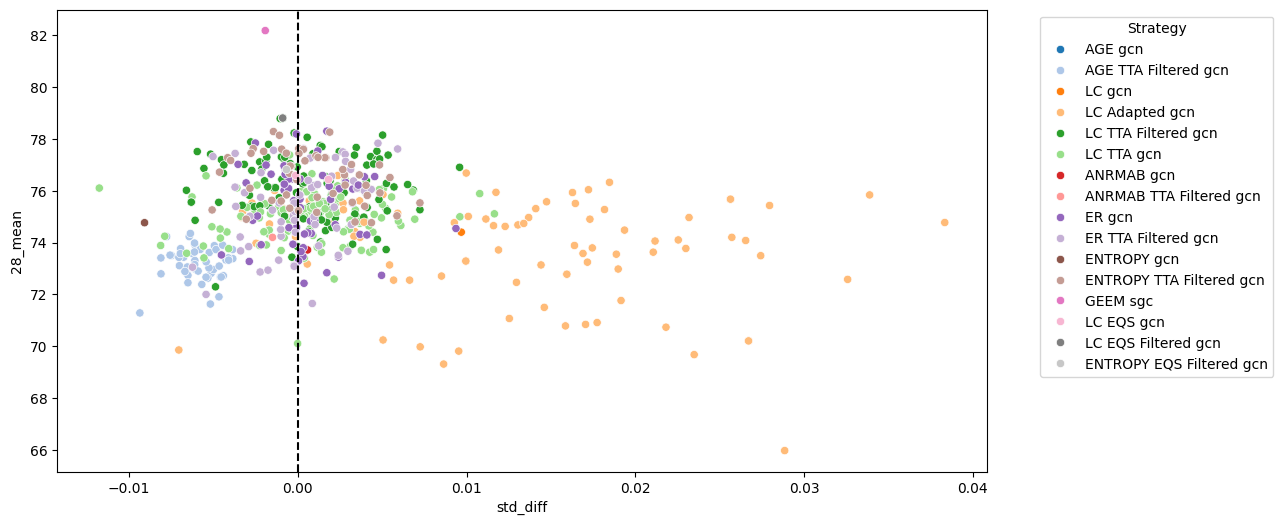

In [74]:
plt.figure(figsize=(12,6))
# to_plot = pd.concat([gcn_cora_df[gcn_cora_df.index.str.contains("None")], highest_28_mean], axis=0)
# to_plot = highest_28_mean
to_plot = gcn_cora_df
sns.scatterplot(data=to_plot, x="std_diff", y="28_mean", hue="name_final", palette="tab20")
plt.axvline(0, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.show()

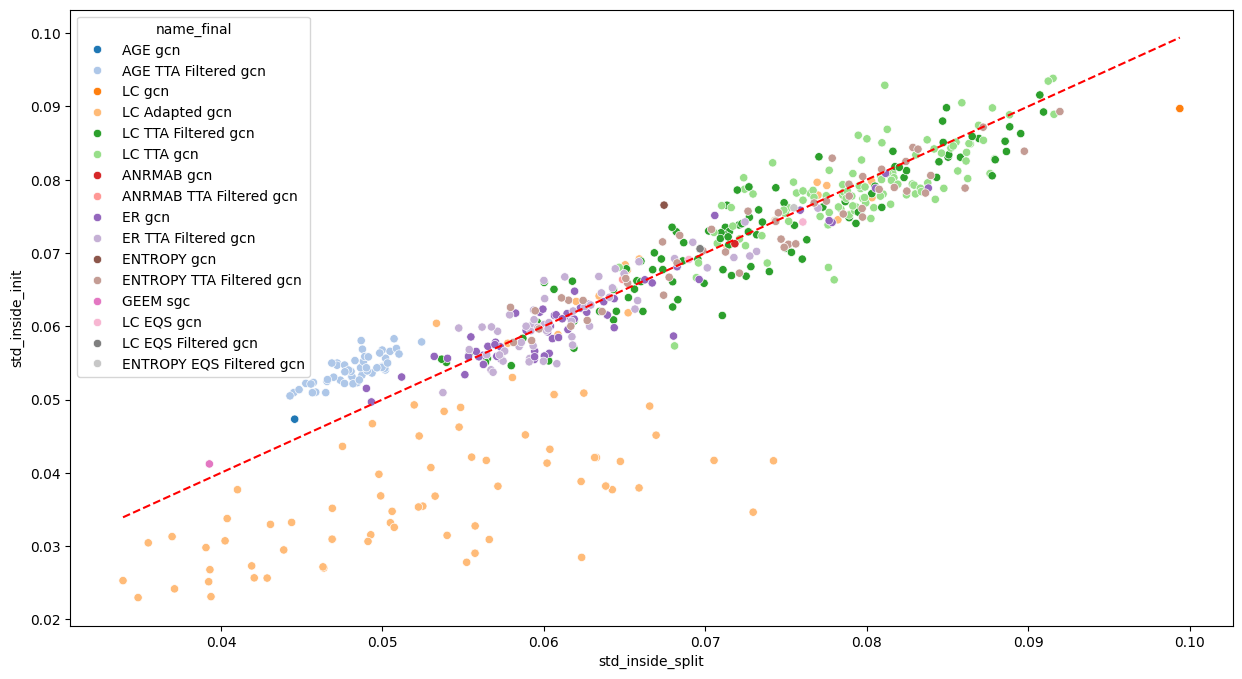

In [65]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=gcn_cora_df, x="std_inside_split", y="std_inside_init", hue="name_final", palette="tab20")
plt.plot([gcn_cora_df["std_inside_split"].min(), gcn_cora_df["std_inside_split"].max()], 
         [gcn_cora_df["std_inside_split"].min(), gcn_cora_df["std_inside_split"].max()], 
         color='red', linestyle='--', label='x=y')

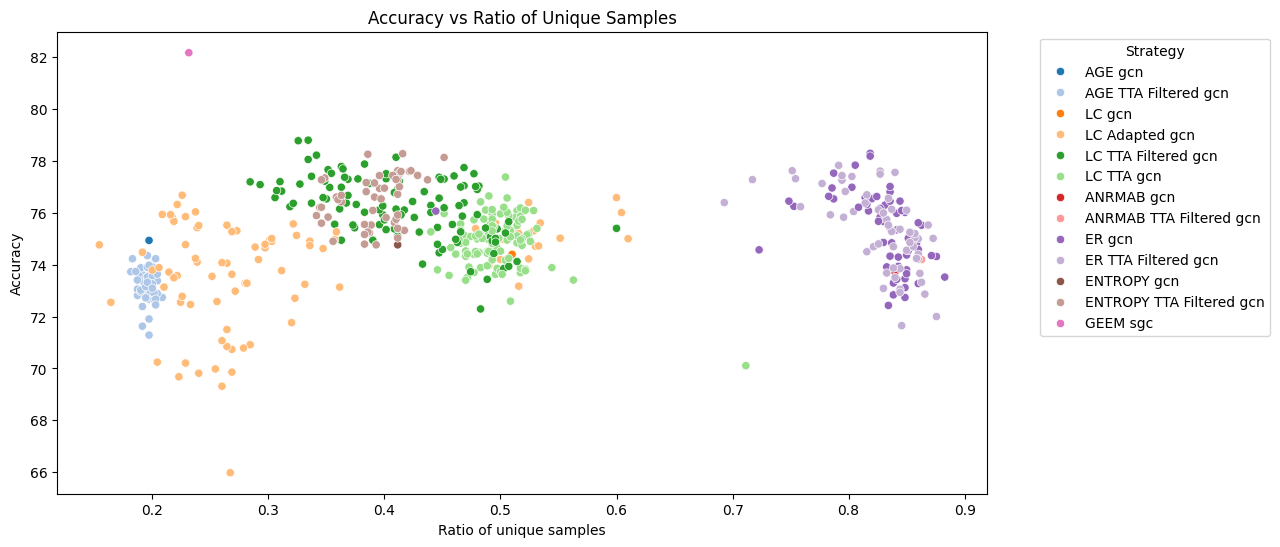

In [69]:
to_plot = big_cora_df[ ~(big_cora_df["tta"] == "EQS")  &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_acquired_indices", y="28_mean", hue="name_final", palette="tab20")
plt.xlabel("Ratio of unique samples")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Ratio of Unique Samples")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
# plt.legend( loc='best', title="Strategy")

plt.show()

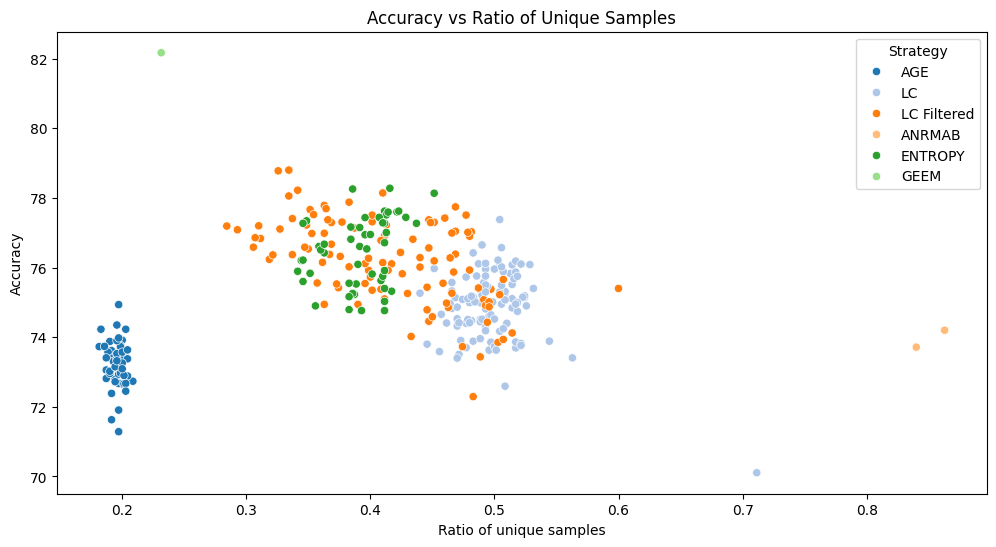

In [72]:
to_plot = big_cora_df[~big_cora_df.index.str.contains("iquery") &  ~(big_cora_df["tta"] == "EQS") & ~big_cora_df.index.str.contains("educated") &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_acquired_indices", y="28_mean", hue="name_final2", palette="tab20")
plt.xlabel("Ratio of unique samples")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Ratio of Unique Samples")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.legend( loc='best', title="Strategy")

plt.show()

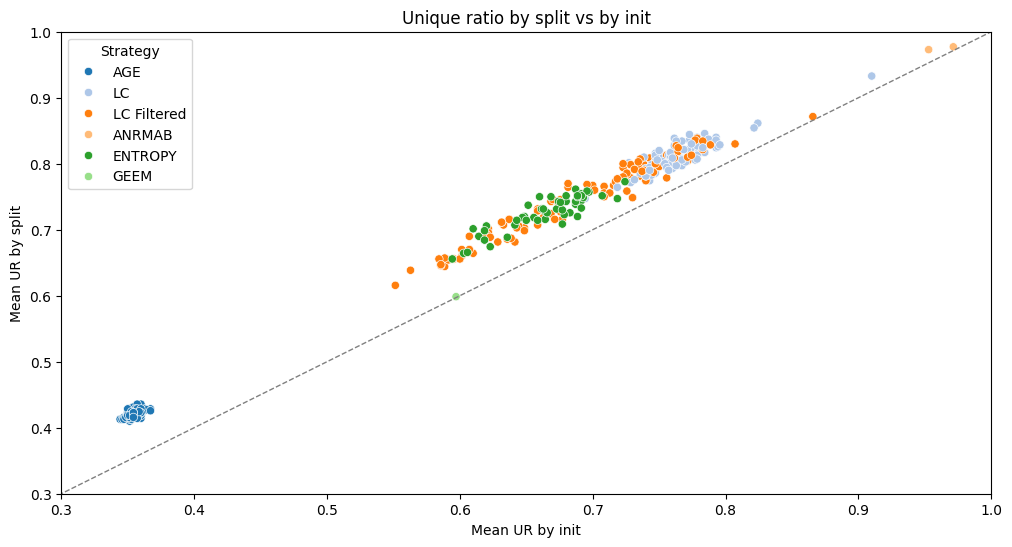

In [28]:
to_plot = big_cora_df[  ~big_cora_df.index.str.contains("iquery") &  ~(big_cora_df["tta"] == "EQS") & ~big_cora_df.index.str.contains("educated") &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_acquired_by_split", y="num_acquired_by_init", hue="name_final2", palette="tab20")
plt.xlabel("Mean UR by init")
plt.ylabel("Mean UR by split")
plt.title("Unique ratio by split vs by init")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.legend( loc='best', title="Strategy")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1)
plt.xlim(0.3, 1)
plt.ylim(0.3, 1)
plt.show()

In [78]:
big_cora_df.loc["geem_sgc"]

0_mean                     39.714286
5_mean                     60.164286
10_mean                    74.664286
15_mean                    78.578572
20_mean                    80.128571
28_mean                    82.171429
0_std                       8.177869
5_std                      10.266465
10_std                      5.058162
15_std                      3.523058
20_std                       3.41684
28_std                      1.165709
0_mean_formatted          39.7 ± 8.2
5_mean_formatted         60.2 ± 10.3
10_mean_formatted         74.7 ± 5.1
15_mean_formatted         78.6 ± 3.5
20_mean_formatted         80.1 ± 3.4
28_mean_formatted         82.2 ± 1.2
nalc                           100.0
num_acquired_indices        0.231429
num_acquired_by_split       0.597143
num_acquired_by_init        0.598571
max_acquired                      19
max_acquired_index                89
strategy                        GEEM
tta                               NO
filter                         False
a

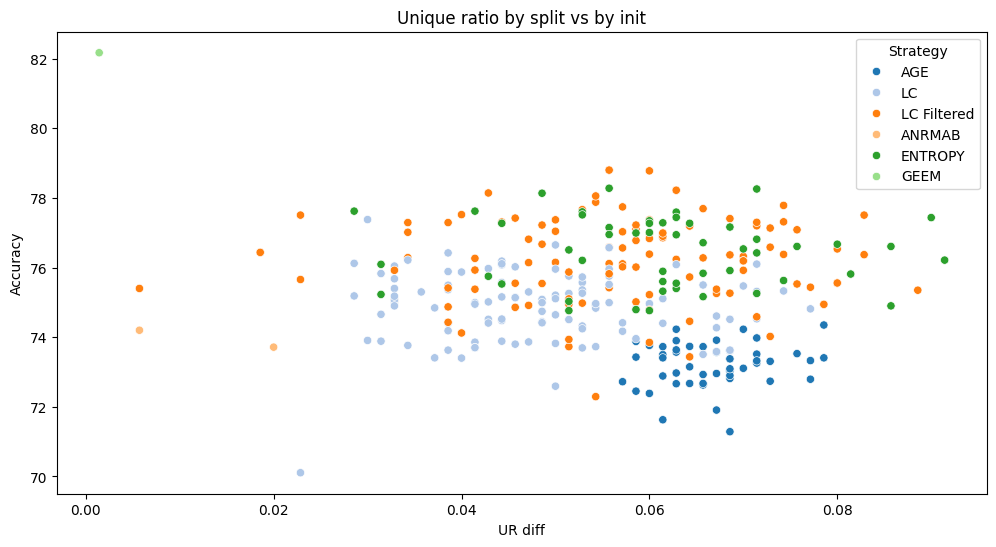

In [79]:
to_plot = big_cora_df[  ~big_cora_df.index.str.contains("iquery") &  ~(big_cora_df["tta"] == "EQS") & ~big_cora_df.index.str.contains("educated") &( (big_cora_df["model"] == "gcn") |(big_cora_df["strategy"] == "GEEM")) ].copy()
to_plot.sort_index(inplace=True)
plt.figure(figsize=(12,6))
sns.scatterplot(data=to_plot, x="num_diff", y="28_mean", hue="name_final2", palette="tab20")
plt.xlabel("UR diff")
plt.ylabel("Accuracy")
plt.title("Unique ratio by split vs by init")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Strategy")
plt.legend( loc='best', title="Strategy")

plt.show()

In [ ]:
# d = []
# for k,v in metrics_dict_cora_gcn.items():
#     cd, c, i = get_count_dict(v[3])
#     d.append([k,len(cd), c.max().item(), c.argmax().item()])

# count_dict_df = pd.DataFrame(d, columns=["key", "num_acquired_indices", "max_acquisitions", "max_acquisition_index"])
# count_dict_df.sort_values(by="num_acquired_indices", ascending=True, inplace=True)
# count_dict_df

In [ ]:
count_dict, count, ixs =  get_count_dict(metrics_dict_cora_gcn[key1][3])

plt.hist(list(count_dict.values()), bins=100)
plt.show()

In [ ]:
key1 = "aleatoric_propagated_None"
key2 = "geem"
d_m_key = ("cora_ml", "sgc")

count_dict_1, count_1, ixs_1 = get_count_dict(all_metrics[d_m_key][key1][3])
# count_dict_1, count_1, ixs_1 = get_count_dict(runs)
print(f"Maximally acquired index: {count_1.argmax()} with {count_1.max()} acquisitions")

count_dict_2, count_2, ixs_2 = get_count_dict(all_metrics[d_m_key][key2][3])
print(f"Maximally acquired index: {count_2.argmax()} with {count_2.max()} acquisitions")
print("------")

print(f"Intersection of acquired indices: {len(set(count_dict_1.keys()).intersection(set(count_dict_2.keys())))}")
print(f"Union of acquired indices: {len(set(count_dict_1.keys()).union(set(count_dict_2.keys())))}")
print(f"{key1} acquired indices: {len(count_dict_1)}")
print(f"{key2} acquired indices: {len(count_dict_2)}")